# Quantum mechanical scattering

This notebook goes through a numerical calculation of the elastic scattering of a non-relativistic quantum particle, using the Born series.

As discussed in class, the key quantity of interest in scattering experiments is the scattering amplitude, $f(\mathbf{k}_i\rightarrow\mathbf{k}_f)$, which describes the quantum amplitude for an incoming plane wave of wavevector $\mathbf{k}_i$ to scatter into wavevector $\mathbf{k}_f$. We will assume 3D space.

## Born series: theory

The Born series formula for the scattering amplitude is

$$f(\mathbf{k}_i\rightarrow \mathbf{k}_f) \approx - \frac{2m}{\hbar^2} \,\cdot \, 2\pi^2 \, \Bigg[\big\langle \mathbf{k}_f\big| \hat{V}\big|\mathbf{k}_i\big\rangle + \big\langle \mathbf{k}_f \big| \hat{V}\hat{G}_0 \hat{V} \big|\mathbf{k}_i\big\rangle + \cdots \Bigg].$$

The particle mass is $m$, the scattering potential operator is $\hat{V}$, the incident wavevector is $\mathbf{k}_i$ and the final wavevector is $\mathbf{k}_f$, and $|\mathbf{k}\rangle$ denotes a momentum eigenstate with wavevector $\mathbf{k}$. We consider elastic collisions, so $|\mathbf{k}_i| = |\mathbf{k}_f| = k$.  The bra-kets can be expressed as integrals by going to the spatial representation:

$$\begin{aligned}\big\langle \mathbf{k}_f\big| \hat{V}\big|\mathbf{k}_i\big\rangle &= \int d^3r_1\; \frac{\exp(-i\mathbf{k}_f \cdot \mathbf{r}_1)}{(2\pi)^{3/2}} \, V(\mathbf{r}_1) \, \frac{\exp(i\mathbf{k}_i \cdot \mathbf{r}_1)}{(2\pi)^{3/2}} \\ &= \frac{1}{(2\pi)^3} \int d^3r_1\; V(\mathbf{r}_1) \; \exp\Big[i(\mathbf{k}_i-\mathbf{k}_f) \cdot \mathbf{r}_1\Big] \end{aligned}$$

and

$$\big\langle \mathbf{k}_f\big| \hat{V} \hat{G}_0\hat{V}\big|\mathbf{k}_i\big\rangle = - \frac{1}{(2\pi)^3} \frac{2m}{\hbar^2} \int d^3r_1 d^3r_2 \; V(\mathbf{r}_1) \; V(\mathbf{r}_2) \; \exp\Big[i\big(\mathbf{k}_i\cdot \mathbf{r}_1 - \mathbf{k}_f \cdot \mathbf{r}_2\big)\Big] \; \frac{\exp[ik|\mathbf{r}_1 - \mathbf{r}_2|]}{4\pi|\mathbf{r}_1 - \mathbf{r}_2|}$$

An expedient way to calculate these integrals is [Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration). Suppose we want to compute an integral of the form


$$I = \int_{V} d^3r \, F(\mathbf{r}),$$

taken over some domain of volume $V$.  We randomly sample $N$ points, $\{F_1, F_2, \dots, F_N\}$.  Then the estimate for the integral is

$$I \,\approx\, \frac{V}{N} \sum_{n=1}^N F_n.$$




## Born series: code

We will assume computational units, $m = \hbar = 1$. First, we import the [Scipy](https://scipy.org/) libraries, and the [Matplotlib](https://matplotlib.org/) library for plotting. Then, we define a function that calculates the first term of the Born series via Monte Carlo integration:

In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt

## Function to estimate the first Born contribution to the scattering amplitude f.
## The inputs are:
##
## Vfun   -- A function object.  The function should take an array [x, y, z]
##           and (optionally) other parameters. It should return V(x,y,z).
## ki, kf -- Initial and final wavevectors, which should have equal magnitudes.
## L      -- Size of sampling box.  Each coordinate is drawn from [-L, L].
## N      -- Number of Monte Carlo runs; default is 5000.
## Vargs  -- A tuple of additional parameters to pass Vfun.

def fborn1(Vfun, ki, kf, L, N, Vargs=()):
    volume = (2*L)**3    # Spatial volume of integration
    f1 = 0.0             # Scattering amplitude
    for n in range(N):
        r1  = 2 * L * np.random.random(3) - L # Each coordinate is -L to L
        dkr = np.dot(ki - kf, r1)
        f1 += - Vfun(r1, *Vargs) * np.exp(1j * dkr) / (2 * np.pi)
    return volume * f1 / N

Here is an explanation of the above code. For $\hbar = m = 1$, the first-order term in the Born series is

$$f^{(1)}(\mathbf{k}_i\rightarrow \mathbf{k}_f) = - \frac{1}{2\pi} \int d^3 r_1 \; V(\mathbf{r}_1)\, \exp\Big[i(\mathbf{k}_i-\mathbf{k}_f) \cdot \mathbf{r}_1\Big].$$

In each Monte Carlo iteration, we draw a random three-component vector $\mathbf{r}_1$ from a cube of side $2L$, centered at the origin (i.e., each coordinate is drawn from a uniform distribution between $-L$ and $L$). Then we calculate the value of the integrand at that sampling point, and add the result to the variable `f1`. After doing this $N$ times, we divide by $N$ to take the mean, and multiply by the volume $V = (2L)^3$ to get the Monte Carlo estimate.

### Task 1 (5 marks)

Write a function `fborn2` to calculate the second-order term in the Born series.  For $\hbar = m = 1$,


$$f^{(2)} = \frac{1}{4\pi^2} \int d^3 r_1 \int d^3r_2  V(\mathbf{r}_1) \; V(\mathbf{r}_2) \; \exp\Big[i\big(\mathbf{k}_i\cdot \mathbf{r}_1 - \mathbf{k}_f \cdot \mathbf{r}_2\big)\Big] \; \frac{\exp[ik|\mathbf{r}_1 - \mathbf{r}_2|]}{|\mathbf{r}_1 - \mathbf{r}_2|}.$$

Hints:
* The double integral can be sampled using a *single* Monte Carlo loop---don't use two nested loops!
* Think about what the hypervolume is. Hint: unlike the first-order Born integral, it's not $(2L)^3$.

In [2]:
## Function to estimate the first Born contribution to the scattering amplitude f.
def fborn2(Vfun, ki, kf, L, N=5000, Vargs=()):
    # Fill in code here
    return 0.0 # FIXME.

## Born series: plotting

We can now use the above code to compute scattering amplitudes. First, let us define a simple scattering potential of the form

$$V(\mathbf{r}) = \begin{cases}-U, & |\mathbf{r}| < 1 \\ 0 & \mathrm{otherwise}\end{cases}$$

This is implemented below with a Python function named `spherical_step_potential`. Note that this describes a potential well for $U > 0$, and a barrier for $U < 0$ (the code should work for both cases).

In [4]:
## Spherical step potential which is U for r < R, and 0 outside
def spherical_step_potential(r, U, R):
    return -U if scipy.linalg.norm(r) < R else 0.0

The following code plots the energy dependence of the scattering amplitude for 90-degree deflection angles, using the first Born approximation.

IntProgress(value=0, max=20)

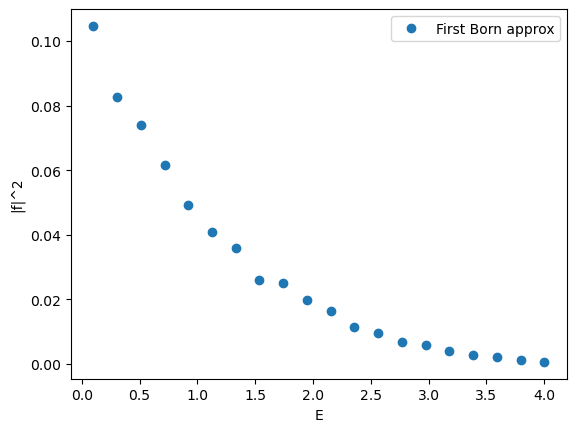

In [5]:
## Plot the differential scattering cross section versus energy E, with
## incident wavevector along (0,0,1) and scattered wavevector along (1,0,0).

def scattering_vs_E_born1():
    from ipywidgets import IntProgress # For progress reporter
    from IPython.display import display

    U, R = 0.5, 1.0 # Potential parameters
    Nmc, Lmc = 5000, 1.0

    ## Monte Carlo parameters

    ## Plotting parameters
    Emin, Emax, numE = 0.1, 4.0, 20

    progress_bar = IntProgress(min=0, max=numE)
    display(progress_bar)
    Evec = np.linspace(Emin, Emax, numE)      # array of energies
    fvec = np.zeros(len(Evec), dtype=complex) # scattering amplitudes to calculate

    for n in range(numE):
        k  = np.sqrt(2*Evec[n])
        ki = np.array([0,0,k])
        kf = np.array([k,0,0])
        fvec[n] = fborn1(spherical_step_potential, ki, kf, Lmc, Nmc, (U, R))
        progress_bar.value += 1

    plt.plot(Evec, abs(fvec)**2, 'o', label='First Born approx')
    plt.xlabel('E'); plt.ylabel('|f|^2'); plt.legend()
    plt.show()

scattering_vs_E_born1()

### Task 2 (5 marks)

By modifying the above code, write a function to plot both the first Born approximation and second Born approximation. Put both graphs **in a single plot**.

Hints:
* The second Born approximation refers to $f^{(1)} + f^{(2)}$, not just $f^{(2)}$.
* Be sure to label the two cases clearly.

In [5]:
def scattering_vs_E_born2():
    ## Fill in code here
    return

scattering_vs_E_born2()

### Task 3 (5 marks)

Write code to plot $|f|^2$ versus deflection angle $\theta$, at a fixed energy $E$, in the first and second Born approximations.

Hints:
* You are free to choose the incident wave-vector $\vec{k}_i$.
* The deflection angle $\theta$ is the angle of $\vec{k}_f$ relative to the direction of $\vec{k}_i$ (e.g., $\theta = 0$ corresponds to the case $\vec{k}_f = \vec{k}_i$). You are free to choose the plane, in 3D space, along which to place $\vec{k}_f$.
* Please include some comments interpreting the results you got. For instance, is the relative strength of forward vs side deflection affected by the strength of the scatterer? Can you give a rough explanation of why?

In [16]:
## Fill in code here
def scattering_vs_theta_born2():
    ## Fill in code here
    return

scattering_vs_theta_born2()

### Task 4 (5 marks)

Investigate the Born scattering amplitudes for a scatterer lacking spherical symmetry.

For this investigation, you will probably have to write your own potential function to replace `spherical_step_potential`, and you can either use the functions in Task 2 and 3, or write fresh code.

In code comments, or an accompanying Jupyter text block, discuss your results. How do the scattering amplitudes differ from a spherically symmetric scatterer?

In [ ]:
## Fill in code here

### Task 5 (10 marks)

We will now compare the Born approximation with the exact results for a uniform spherical scatterer.

The derivation of the exact scattering amplitude, based on partial wave analysis, is given in Appendix A of the course notes. The end result is

$$\begin{aligned}f(\mathbf{k}_i \rightarrow k\hat{\mathbf{r}}) &= \frac{1}{2ik}\, \sum_{\ell =0}^\infty \big(e^{2i\delta_\ell} - 1\big) \big(2\ell+1\big)\, P_{\ell}(\hat{\mathbf{k}}_i\cdot \hat{\mathbf{r}}) \\ \delta_\ell &= \frac{\pi}{2} - \mathrm{arg}\!\left[k{h_\ell^+}'(kR) \, j_\ell(qR) - qh_\ell^+(kR)\, j_\ell'(qR)\right] \\ k &= |\mathbf{k}_i| = \sqrt{2mE/\hbar^2}, \;\; q = \sqrt{2m(E+U)/\hbar^2},\end{aligned}$$

where $V_0$ is the potential inside the sphere of radius $R$.

Write a program to plot $|f|^2$ versus $E$ for (i) first-order Born, (ii) second-order Born, and (iii) the exact result, on a single graph.

Hints:
* To compute the Legendre polynomials $P_\ell(x)$, use [`scipy.special.lpmv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.lpmv.html).<br />Note that $P_\ell$ is what the documentation refers to as $P_\ell^0$ (i.e., the "zeroth-order" associate Lgendre polynomial).
* To compute the spherical Hankel function of the first kind ($h_\ell^+$) or its derivative (${h_\ell^+}'$), use the identity $h_\ell^+ = j_\ell + i y_\ell$.
* To compute the spherical Bessel function of the first kind ($j_\ell$) or its first derivative ($j_\ell'$), use [`scipy.special.spherical_jn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.spherical_jn.html).
* To compute the spherical Bessel function of the second kind ($y_\ell$) or its first derivative ($y_\ell'$), use [`scipy.special.spherical_yn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.spherical_yn.html).
* The argument of a complex number can be calculated using [`numpy.angle`](https://numpy.org/doc/stable/reference/generated/numpy.angle.html).
* We have defined $U > 0$ to mean a potential well. Preferably, your code should also work for the $U < 0$ case (a potential barrier).

In [6]:
## Fill in code here